In [1]:
import numpy as np
import matplotlib.pyplot as plt
import admm_fq_base as adfb
import admm_fq_huffman as adfvar
import utils
import importlib
import huffman as huf

In [18]:
importlib.reload(adfb)
importlib.reload(adfvar)
importlib.reload(utils)

<module 'utils' from '/home/matthias/repos/python_utils/utils.py'>

In [89]:
rng = np.random.default_rng()
L = 16

In [90]:
nwb = adfb.Network(L)
nwb.addNode(0, 1.0)
nwb.addNode(1, 1.0)
nwb.addNode(2, 1.0)
nwb.setConnection(0, [1])
nwb.setConnection(1, [2])
nwb.setConnection(2, [0])

nwvar = adfvar.Network(L)
nwvar.addNode(0, 1.0)
nwvar.addNode(1, 1.0)
nwvar.addNode(2, 1.0)
nwvar.setConnection(0, [1])
nwvar.setConnection(1, [2])
nwvar.setConnection(2, [0])

# nwpr = adfpr.Network(L)
# nwpr.addNode(0)
# nwpr.addNode(1)
# nwpr.addNode(2)
# nwpr.setConnection(0, [1])
# nwpr.setConnection(1, [2])
# nwpr.setConnection(2, [0])

# nwar = adfar.Network(L)
# nwar.addNode(0)
# nwar.addNode(1)
# nwar.addNode(2)
# nwar.setConnection(0, [1])
# nwar.setConnection(1, [2])
# nwar.setConnection(2, [0])

In [277]:
nr_codebook_samples = 1000000
mean = 0
sd = 0.01
decimals = 10
training_data = rng.normal(mean, sd, (nr_codebook_samples,))
training_data = np.concatenate([training_data, np.zeros((int(nr_codebook_samples / 15),))])

sd_mult = 4
hist_range = [-sd_mult*sd,sd_mult*sd]
nr_bins = 301
step = (hist_range[1] - hist_range[0]) / nr_bins
bins = np.arange(hist_range[0], hist_range[1] + step, step)
centers = ((bins[1:] + bins[:-1]) / 2).round(12)
resample_hist_range = hist_range
resample_nr_bins = 11
resample_step = (resample_hist_range[1] - resample_hist_range[0]) / resample_nr_bins
resample_bins = np.arange(
    resample_hist_range[0], resample_hist_range[1] + resample_step, resample_step
)
resample_centers = ((resample_bins[1:] + resample_bins[:-1]) / 2).round(10)
resample_bins_ = resample_bins
resample_bins_[0] = -np.inf
resample_bins_[-1] = np.inf

In [278]:
resample_training_data = np.array([])
for i, cent in enumerate(resample_centers):
    pp = training_data[np.isclose(training_data, cent, atol=step / 2)]
    resample_training_data = np.concatenate(
        [resample_training_data, np.ones(pp.shape) * i]
    )

resample_training_data = resample_training_data.astype(int)

In [279]:
# resample_training_data = np.searchsorted(resample_bins_, training_data, side="left")-1

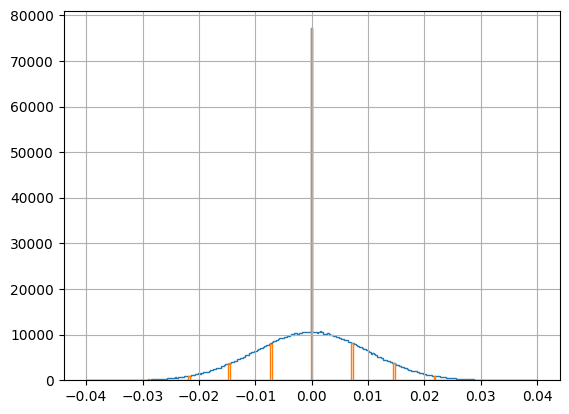

In [280]:
counts, bins = np.histogram(training_data, bins)
plt.stairs(counts, bins)
counts, bins = np.histogram(resample_centers[resample_training_data], bins)
plt.stairs(counts, bins)
plt.grid()
plt.show()

In [281]:
data = list(resample_training_data)
encoded, tree = huf.huffman_encode(data)
table = huf.huffman_table(tree)

# Pretty print the Huffman table
print(f"Symbol Code\n------ ----")
for i, (k, v) in enumerate(
    sorted(huf.huffman_table(tree).items(), key=lambda x: len(x[1]))
):
    # if i > 10:
    #     break
    print(f"{k:<6} {v}")

# Print the bit pattern of the encoded data
# print("".join(hf._bits_from_bytes(encoded)))

# Encode then decode
decoded = huf.huffman_decode(encoded, tree)
numbers_decoded = list(decoded)

# print(numbers - numbers_decoded)
print("Error:", np.linalg.norm(resample_training_data - numbers_decoded))

# print(numbers - numbers_decoded)
print(
    "Error:",
    np.linalg.norm(
        resample_centers[resample_training_data] - resample_centers[numbers_decoded]
    ),
)

Symbol Code
------ ----
5      1
7      000
4      010
6      011
3      0011
2      00100
8      001011
1      0010101
9      00101001
10     001010000
0      0010100011
256    00101000100
11     00101000101
Error: 0.0
Error: 0.0


In [269]:
rho = 1
stepsize = 0.8
eta = 0.98
M = nwb.N
nr_samples = 100000
partitions = 2
part_len = int(nr_samples / partitions)

true_norms = [1.0, 1.0, 1.0, 1.0]

u = rng.normal(size=(nr_samples, 1))
clean_signal: np.ndarray = u / u.max()

clean_signal = clean_signal / clean_signal.std(axis=0) * 0.25

In [270]:
h = {}
hf = {}
for part in range(partitions):
    h_, hf_ = utils.generateRandomIRs(L, M, true_norms, rng)
    h[part] = h_
    hf[part] = hf_

In [271]:
SNR = 40
noisy_signals = np.empty((0, M))
for part in range(partitions):
    noisy_signals_ = utils.getNoisySignal(
        clean_signal[part * part_len : (part + 1) * part_len], h[part], SNR, rng
    )
    noisy_signals = np.concatenate([noisy_signals, noisy_signals_])

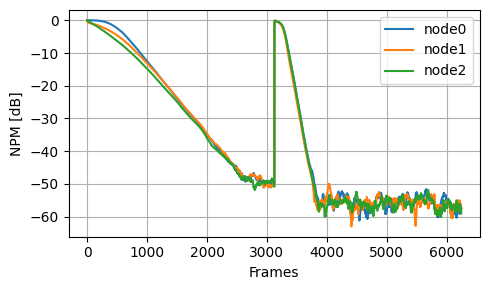

In [272]:
transmission_hist = {}
hopsize = L
npm = []
# nw.setOnTransmit(saveTransmissionHist)
nwb.reset()
nwb.setParameters(rho, stepsize, eta, 1, 0.0)
# nwb.setDeltas(1e-8, 0.1, 0.1, 2, 0.001)
for k_admm_fq in range(0, nr_samples - 4 * L, hopsize):
    nwb.step(noisy_signals[k_admm_fq : k_admm_fq + 2 * L, :])
    error = []
    for m in range(M):
        node: adfb.NodeProcessor = nwb.nodes[m]
        error.append(
            utils.NPM(
                node.getEstimate(), hf[utils.getPart(k_admm_fq, part_len)][:, m, None]
            )
        )
    # npm.append(np.mean(error))
    npm.append(error)
npm = np.asarray(npm)
nw_ = nwb

fig = plt.figure(figsize=(5, 3))
# plt.title(rf"SNR={SNR}dB")
plt.xlabel("Frames")
plt.ylabel("NPM [dB]")
labels = [f"node{label}" for label in range(M)]
plt.plot(20 * np.log10(npm), label=labels)
# plt.ylim(-50, 0)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
utils.savefig(fig, "npm")

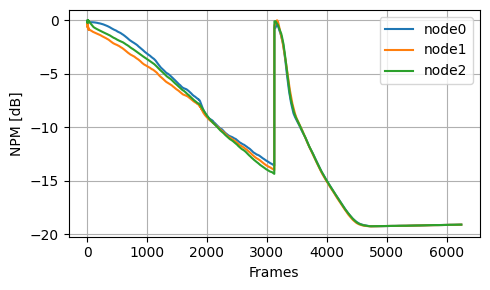

In [287]:
transmission_hist = {}
hopsize = L
increase_mult = 1.2
decrease_mult = 0.8
inc_lim = 0.5
dec_lim = 1.5
npm = []
# nw.setOnTransmit(saveTransmissionHist)
nwvar.reset()
nwvar.setParameters(rho, stepsize, eta)
nwvar.setCodeBook(
    tree,
    table,
    resample_bins_,
    resample_centers,
    sd**2,
    increase_mult,
    decrease_mult,
    inc_lim,
    dec_lim,
)
# nwvar.setDeltas(1e-8, 0.1, 0.1, 2, 0.001)
for k_admm_fq in range(0, nr_samples - 2 * L, hopsize):
    nwvar.step(noisy_signals[k_admm_fq : k_admm_fq + 2 * L, :])
    error = []
    for m in range(M):
        node: adfb.NodeProcessor = nwvar.nodes[m]
        error.append(
            utils.NPM(
                node.getEstimate(), hf[utils.getPart(k_admm_fq, part_len)][:, m, None]
            )
        )
    # npm.append(np.mean(error))
    npm.append(error)
npm = np.asarray(npm)
nw_ = nwvar

fig = plt.figure(figsize=(5, 3))
# plt.title(rf"SNR={SNR}dB")
plt.xlabel("Frames")
plt.ylabel("NPM [dB]")
labels = [f"node{label}" for label in range(M)]
plt.plot(20 * np.log10(npm), label=labels)
# plt.ylim(-50, 0)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()
utils.savefig(fig, "npm")

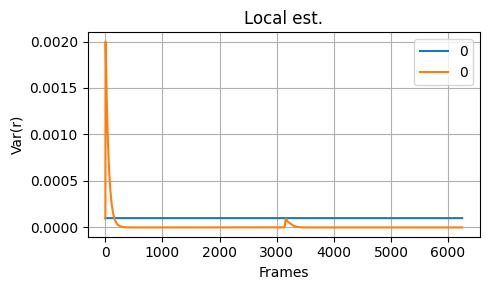

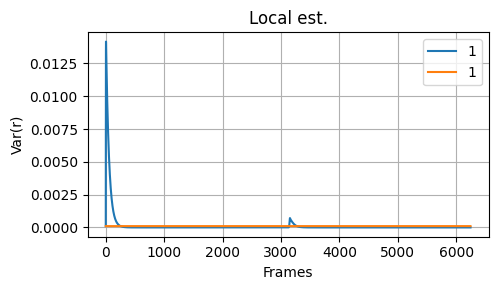

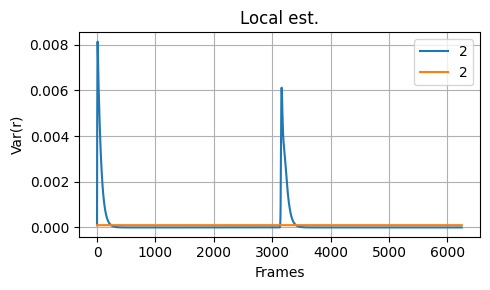

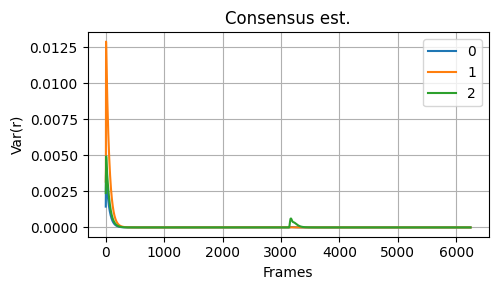

In [288]:
# %%
# labels = [f"node{label}" for label in range(M)]
for node in nwvar.nodes.values():
    fig = plt.figure(figsize=(5, 3))
    plt.title(rf"Local est.")
    plt.xlabel("Frames")
    plt.ylabel("Var(r)")
    plt.plot(node.res_local_var_hist, label=node.id)
    # plt.xlim(0, 2500)
    # plt.ylim(0, 0.0000002)
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.show()

# %%
fig = plt.figure(figsize=(5, 3))
plt.title(rf"Consensus est.")
plt.xlabel("Frames")
plt.ylabel("Var(r)")
# labels = [f"node{label}" for label in range(M)]
for node in nwvar.nodes.values():
    plt.plot(node.res_consensus_var_hist, label=node.id)
# plt.xlim(0, 2500)
# plt.ylim(0, 0.0000004)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

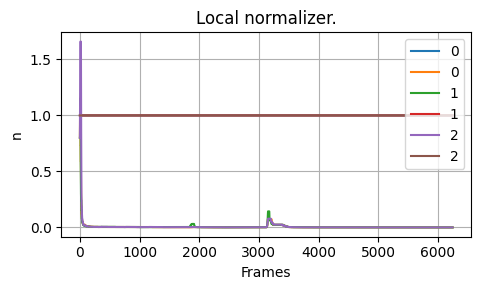

In [289]:
# %%
fig = plt.figure(figsize=(5, 3))
plt.title(rf"Local normalizer.")
plt.xlabel("Frames")
plt.ylabel("n")
# labels = [f"node{label}" for label in range(M)]
for node in nwvar.nodes.values():
    plt.plot(node.local_enc_normalizer_hist, label=node.id)
# plt.xlim(0, 2500)
# plt.ylim(0, 1000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

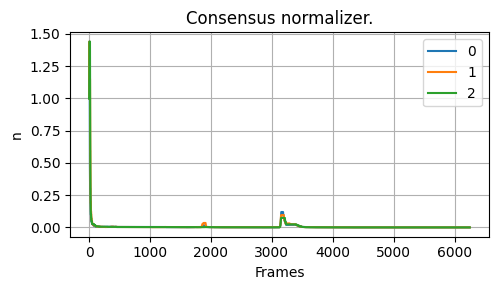

In [290]:
# %%
fig = plt.figure(figsize=(5, 3))
plt.title(rf"Consensus normalizer.")
plt.xlabel("Frames")
plt.ylabel("n")
# labels = [f"node{label}" for label in range(M)]
for node in nwvar.nodes.values():
    plt.plot(node.consensus_enc_normalizer_hist, label=node.id)
# plt.xlim(0, 2500)
# plt.ylim(0, 1000)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [183]:
len(resample_centers)

101